In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import os 
import sys 

current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..','..','..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    
from pipeline.plotting.TS_analysis import plot_TS
from pipeline.plotting.plotting_boxplot_metrics import plot_boxplot_on_metric
from experiences.convert_df_to_latex import dataframe_to_latex,parse_index_exp1_2,parse_index_exp4,results_to_dataframe



folder_path = 'save/K_fold_validation/training_wo_HP_tuning'

In [ ]:
def plot_metrics(df, target_name, configurations,folder_path,add_name = '',title = 'Prediction of',rainy = False,ylim = None,
                 rainy_percentage_in_train = None,
                 dic_rainfall = None,
                 gain=False,
                 metrics = ['RMSE', 'MAE', 'MASE']):
    """
    This function plots RMSE, MAE, and MASE metrics for different configurations and training data percentages.
    """
    cmap = plt.colormaps.get_cmap('cool')
    if add_name == 'rainy_':
        rainy = True

    for horizon in sorted(df['horizon'].unique()):
        fig, axes = plt.subplots(1, len(metrics), figsize=(10, 5))
        if rainy:
            fig.suptitle(f'{title} {target_name.replace("_", " ")} on Rainy time-slots at horizon {horizon} according to training data quantity', fontsize=16)
        else:
            fig.suptitle(f'{title} {target_name.replace("_", " ")} at horizon {horizon} according to training data quantity', fontsize=16)

        colors = plt.cm.viridis(np.linspace(0, 1, len(configurations)))
        colors = plt.cm.get_cmap('Dark2', len(configurations)).colors

        all_handles = []
        all_labels = []
        for i, metric in enumerate(metrics):
            ax = axes[i]

            for color, config in zip(colors, configurations):

                subset = df[(df['contextual_data'] == config) & (df['horizon'] == horizon)]
                
                if subset.empty:
                    continue


                grouped = subset.groupby(['horizon','percentage'])[metric]


                
                mean_metric = grouped.mean()
                min_metric = grouped.min()
                max_metric = grouped.max()

                percentages = sorted(subset['percentage'].unique())
                
                label = config.replace(f"{target_name}", "").replace("_", " ").strip()
                if not label:
                    label = target_name.replace("_", " ")

                line, = ax.plot(percentages, mean_metric, marker='o', linestyle='-', label=label, color=color)
                ax.fill_between(percentages, min_metric, max_metric, alpha=0.2, color=color)

                # Add to legend list, but only if the label is new
                if label not in all_labels:
                    all_labels.append(label)
                    all_handles.append(line)

            ax.set_title(metric)
            ax.set_xlabel('Pourcentage of training data used (%)')
            ax.set_ylabel(metric)
            if ylim is not None:
                ymin,ymax = ylim
                ax.set_ylim(ymin, ymax)
            ax.grid(True)
            # ax.legend()
                    
            if rainy and rainy_percentage_in_train is not None:
                # Vérifier la correspondance des longueurs
                if len(percentages) != len(rainy_percentage_in_train):
                    print(f"Warning for h={horizon}: Length mismatch. Cannot plot rainy percentage.")
                else:

                    ax2 = ax.twinx()  # Build a second y-
                    label_ax2 = '% of rainy time-slots'
                    # ax2.plot(percentages, rainy_percentage_in_train, color='blue', linestyle='--', marker='x')
                    line, = ax2.plot(percentages, rainy_percentage_in_train, color='blue', linestyle='--', marker='x', label=label_ax2)  # ???
                    if label_ax2 not in all_labels:
                        all_labels.append(label_ax2)
                        all_handles.append(line)


                    if dic_rainfall is not None:
                        N = len(dic_rainfall.keys())
                        points = np.linspace(0, 1, N)
                        colors_rainfall = cmap(points)
                        for k,((rainfall_min, rainfall_max), values) in enumerate(dic_rainfall.items()):
                            label_rain_cat = f'% of Rainfall {rainfall_min}-{rainfall_max} mm/h among rainy time-slots within training'
                            line, = ax2.plot(percentages, values, color = colors_rainfall[k], alpha = 0.3, linestyle='--', marker='x', 
                                            label=label_rain_cat)
                            if label_rain_cat not in all_labels:
                                all_labels.append(label_rain_cat)
                                all_handles.append(line)
                    # Définir le label de l'axe Y de droite
                    ax2.set_ylabel('% of rainy time-slots within training') # ,color = 'blue'
                    
                    # Définir les limites de l'axe Y de droite
                    ax2.set_ylim(0, 41)
                    
                    ax2.tick_params(axis='y') # , labelcolor='blue'

                    # ax2.legend(loc='upper left')


        # if gain == True, then plot a horizontal line at y=0 showing the gain compared to the baseline (first configuration)
        if gain: 
            for ax in axes:
                ax.axhline(0, color='black', linestyle='--')
        
        fig.legend(all_handles, all_labels, 
                        loc='lower center',       # Position at the bottom, centered
                        bbox_to_anchor=(0.5, -0.01),# Anchor point (0.5=center, 0.0=bottom of figure)
                        ncol=2,                   # Adjust 'ncol' as needed
                        fontsize='small')

                      # rect=[left, bottom, right, top]
        plt.tight_layout(rect=[0, 0.1, 1, 0.96]) # Leave 10% space at bottom, 4% at top
        if folder_path is not None: 
            plt.savefig(f"{folder_path}/{target_name}_h{horizon}_{add_name}metrics_comparison.png")
        plt.show()



# from experiences.contextual_data_integration.B_data_quantity.exp5_results import results
# from experiences.contextual_data_integration.B_data_quantity.exp5_rainy_results import results
# from experiences.contextual_data_integration.B_data_quantity.exp5_train_size_results import results
from experiences.contextual_data_integration.B_data_quantity.exp5_train_size_rainy_results import results

df = results_to_dataframe(results)
display(df)

,target,contextual_data,percentage,horizon,bis,RMSE,MAE,MASE
0,bike_out,bike_out,5,1,1,4.832,3.010,0.897
1,bike_out,bike_out,5,1,2,4.784,3.002,0.895
2,bike_out,bike_out,5,1,3,4.825,3.066,0.914
3,bike_out,bike_out,5,1,4,4.887,3.057,0.911
4,bike_out,bike_out,5,1,5,4.699,2.980,0.888
...,...,...,...,...,...,...,...,...
345,subway_out,subway_out + subway-in + weather,100,4,1,38.840,21.884,0.437
346,subway_out,subway_out + subway-in + weather,100,4,2,38.566,21.659,0.432
347,subway_out,subway_out + subway-in + weather,100,4,3,39.043,21.976,0.438
348,subway_out,subway_out + subway-in + weather,100,4,4,38.773,21.969,0.438


/tmp/ipykernel_263297/3553902335.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2', len(configurations)).colors


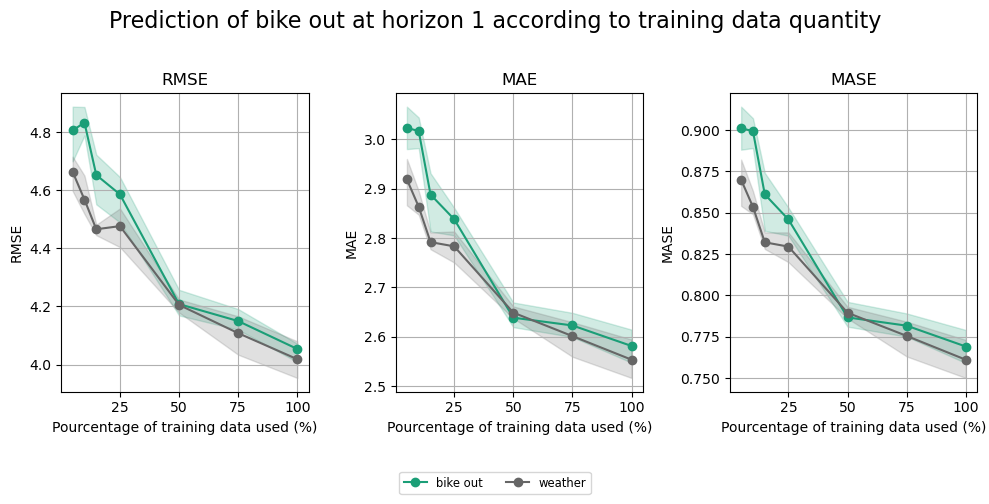

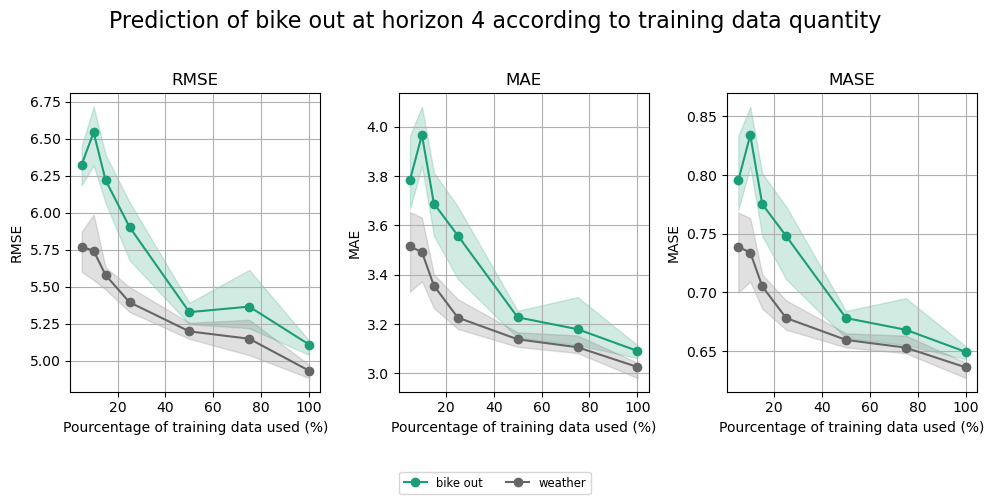

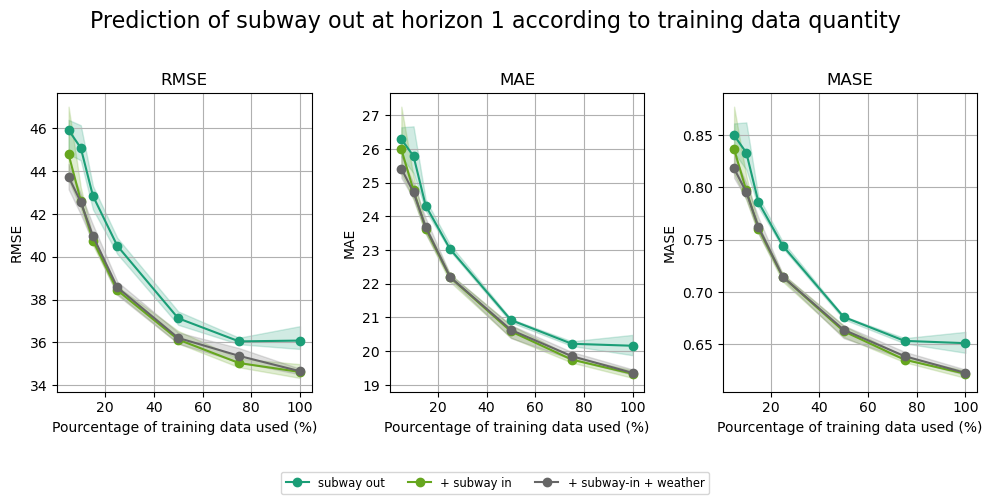

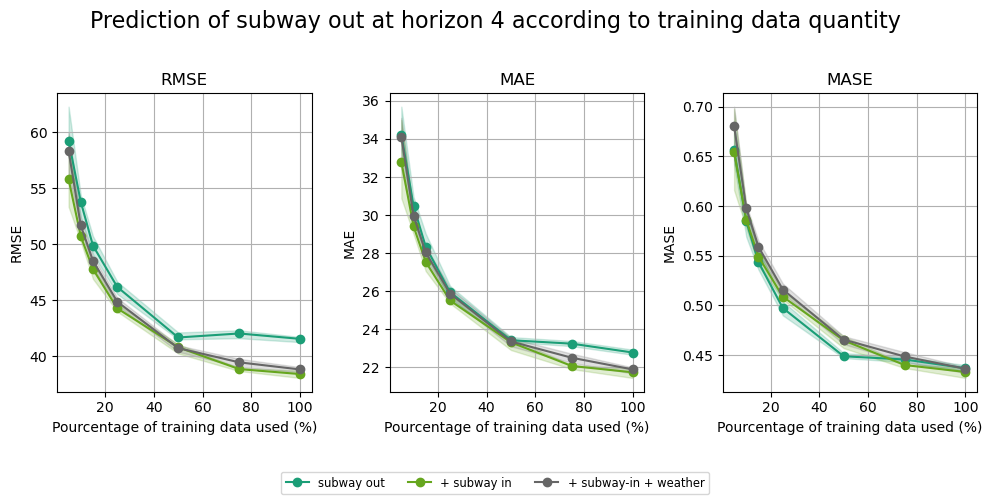

In [27]:
save_folder_path = None # 'save/plots' # 'experiences/contextual_data_integration/B_data_quantity/plots'

target2config = {'bike_out': ['bike_out', 'bike_out_weather'],
              'subway_out': ['subway_out', 'subway_out + subway in', 'subway_out + subway-in + weather']         
              }


if False: 
    target = 'bike_out'
    plot_metrics(df[df['target'] == target], target, target2config[target],save_folder_path,add_name = 'rainy_')

    target = 'subway_out'
    plot_metrics(df[df['target'] == target], target, target2config[target],save_folder_path,add_name = 'rainy_')

if True:
    bike_out_configs = ['bike_out', 'bike_out_weather']
    plot_metrics(df[df['target'] == 'bike_out'], 'bike_out', bike_out_configs,save_folder_path, add_name = 'expanding_train_')

    subway_out_configs = ['subway_out', 'subway_out + subway in', 'subway_out + subway-in + weather']
    plot_metrics(df[df['target'] == 'subway_out'], 'subway_out', subway_out_configs,save_folder_path, add_name = 'expanding_train_')

## PLot mean Gain % through config

- To use it, change the lines :
    - `script = 'exp5_rainy_results' if rainy else 'exp5_results'` 
    -  `add_name = 'random_train_'`

- with  
    - `script = 'exp5_train_size_rainy_results' if rainy else 'exp5_train_size_results'`
    - `add_name = 'expanding_train_'`


/tmp/ipykernel_263297/3436402974.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2', len(configurations)).colors


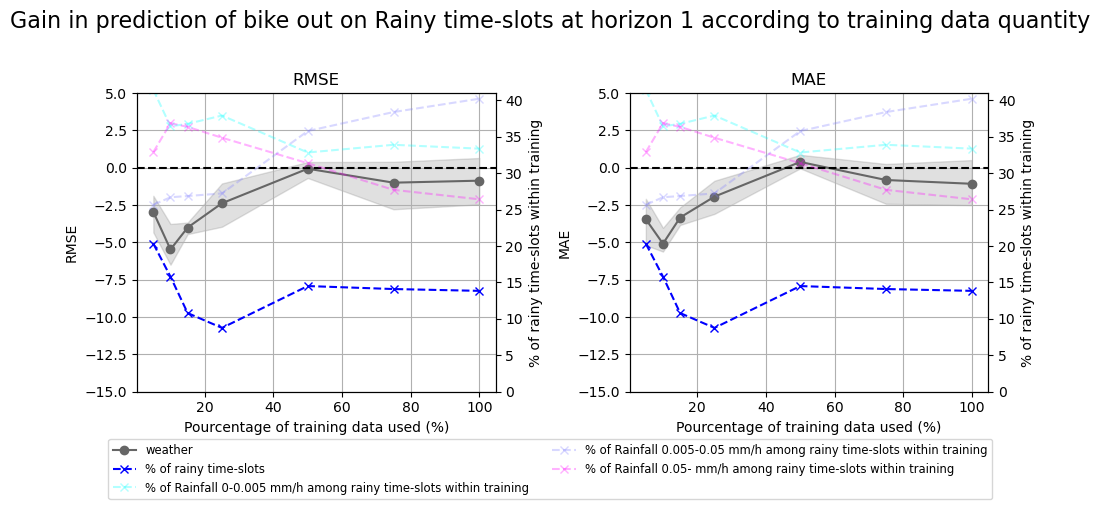

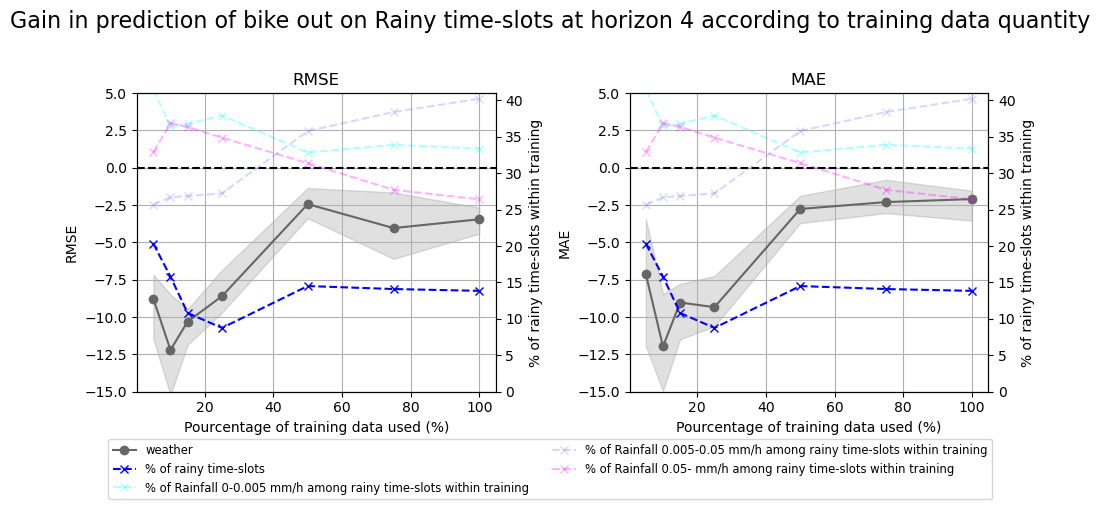

/tmp/ipykernel_263297/3436402974.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2', len(configurations)).colors


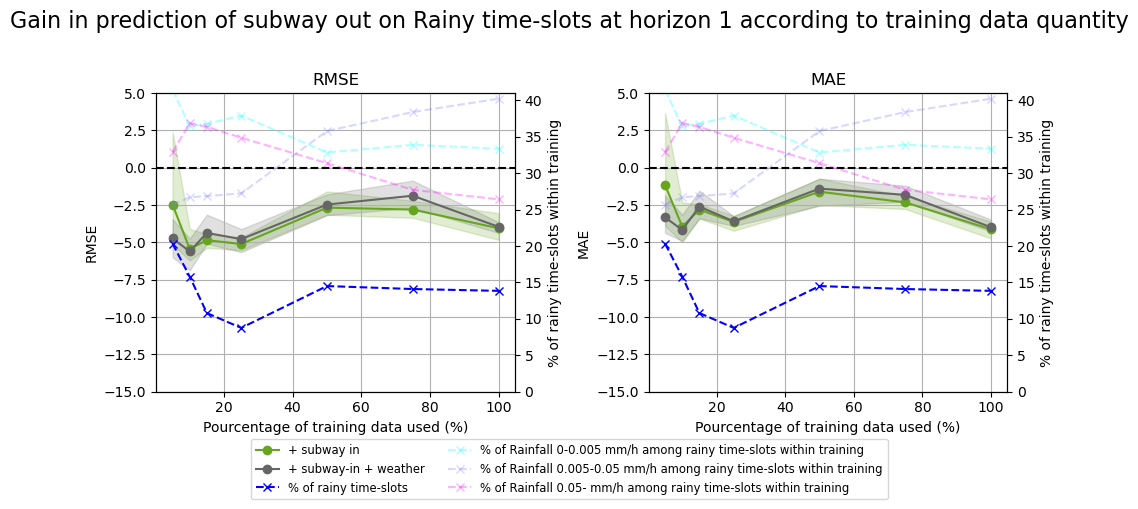

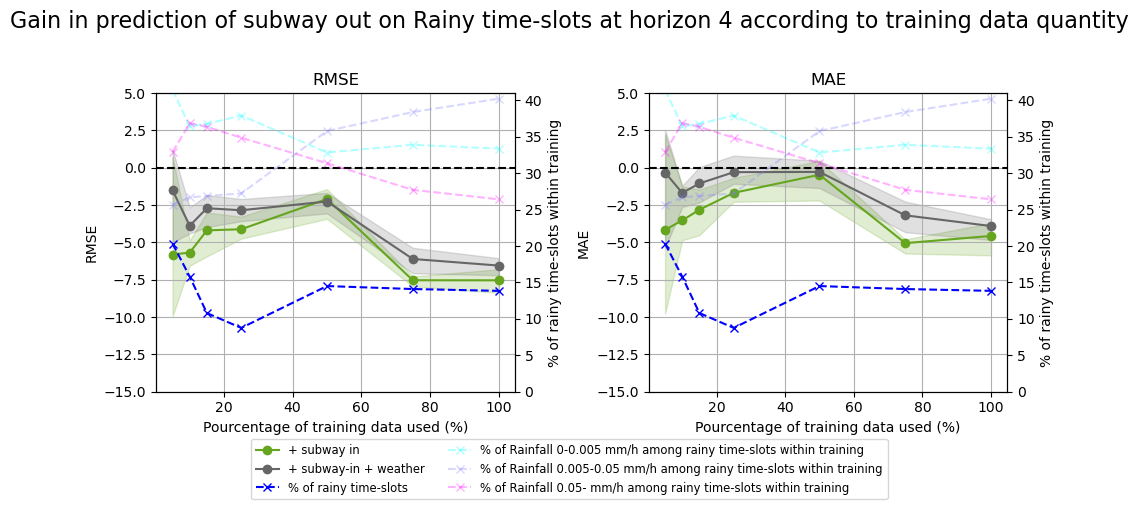

/tmp/ipykernel_263297/3436402974.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2', len(configurations)).colors


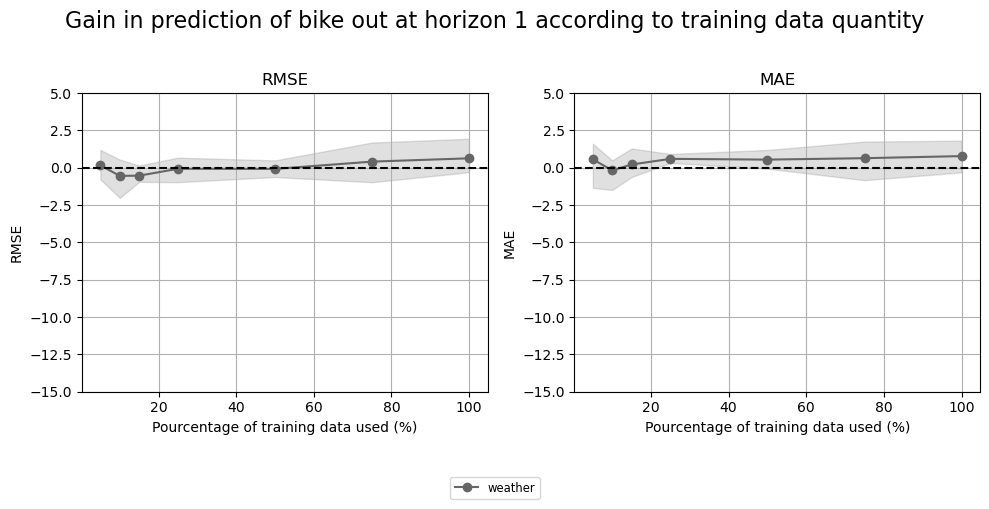

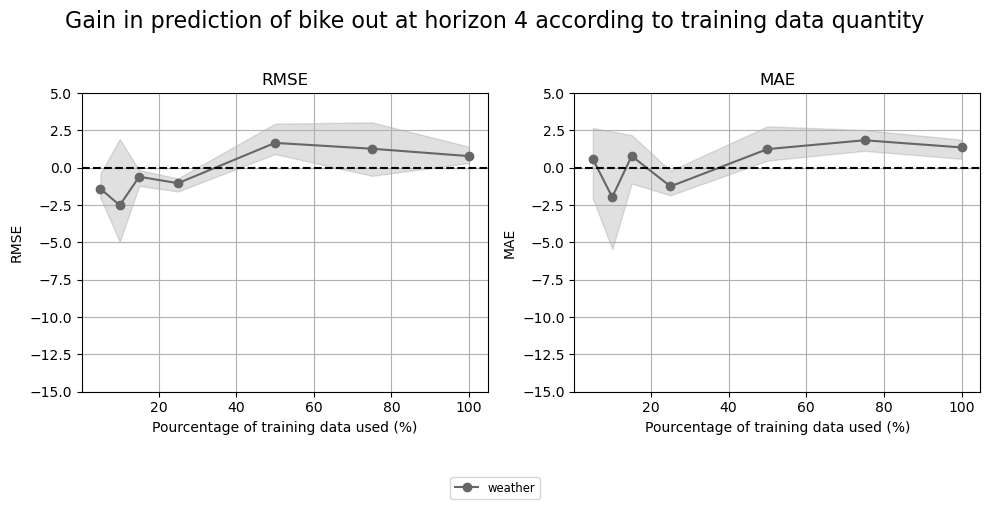

/tmp/ipykernel_263297/3436402974.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2', len(configurations)).colors


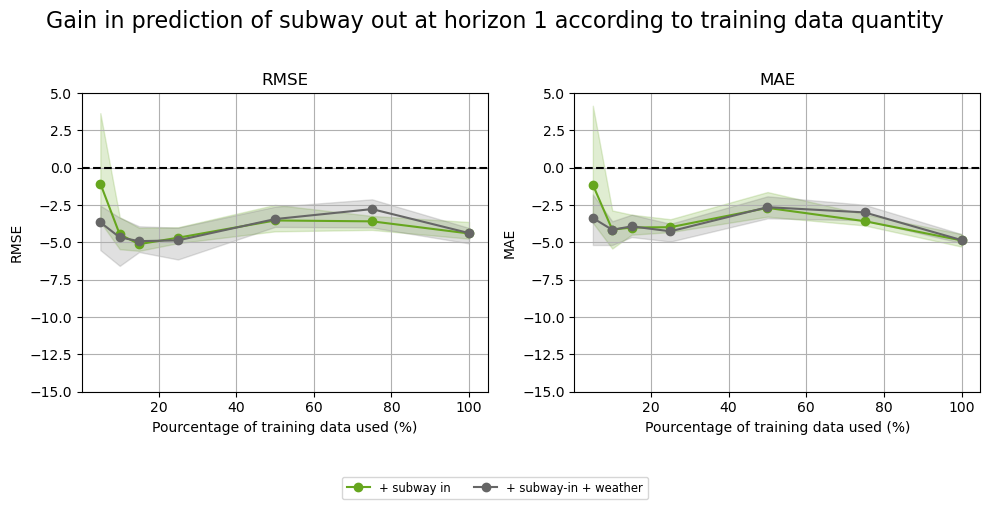

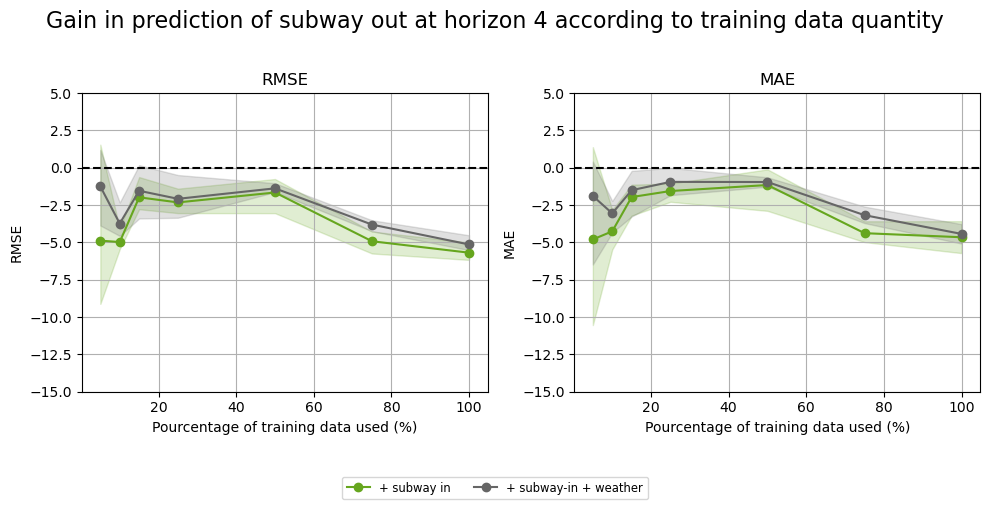

In [39]:
# from experiences.contextual_data_integration.B_data_quantity.exp5_results import results
# from experiences.contextual_data_integration.B_data_quantity.exp5_rainy_results import results
# from experiences.contextual_data_integration.B_data_quantity.exp5_train_size_results import results
# from experiences.contextual_data_integration.B_data_quantity.exp5_train_size_rainy_results import results
import importlib 

save_folder_path = 'experiences/contextual_data_integration/B_data_quantity/plots' # 'experiences/contextual_data_integration/B_data_quantity/plots' #None # 'save/plot'

dic_rainfall_init = {('0','0.05'):[41.45,36.44, 36.78, 37.92,32.84,33.90,33.37],
                    # ('0.005','0.01'): [7.24,8.05,7.85,6.73,12.73,14.55,14.49],
                    # ('0.01','0.05'): [18.42,18.64,19.01,20.49,23.06,23.85,25.74],
                    ('0.05','0.5'): [18.42+7.24,
                                       18.64+8.05,
                                       19.01+7.85,
                                       20.49+6.73,
                                       23.06+12.73,
                                       23.85+14.55,
                                       25.74+14.49],
                    ('0.5',''): [14.47+18.42+0.00,
                                16.53+20.34+0.00,
                                16.53+19.83+0.00,
                                17.74+16.21+0.92,
                                15.13+14.30+1.94,
                                12.97+12.21+2.53,
                                13.33+10.86+2.22
                                ]
                    }

# dic_rainfall_init = {('0','0.05'):[8.42,5.75, 3.96, 3.31,4.76,4.78,4.62],
#                     # ('0.05','0.1'): [1.47,1.27,0.85,0.59,1.84,2.05,2.00],
#                     # ('0.1','0.5'): [3.74,2.94,2.05,1.79,3.34,3.36,3.56],
#                     ('0.05','0.5'): [3.74+1.47,2.94+1.27,2.05+0.85,1.79+0.59,3.34+1.84,3.36+2.05,3.56+2.00],
#                     ('0.5',''): [2.94+3.74+0.00,
#                                     2.61+3.21+0.00,
#                                     1.78+2.14+0.00,
#                                     1.55+1.42+0.08,
#                                     2.19+2.07+0.28,
#                                     1.83+1.72+0.36,
#                                     1.84+1.50+0.31
#                                         ]
#                     }

for rainy in [True,False]:
    script = 'exp5_train_size_rainy_results' if rainy else 'exp5_train_size_results'
    # script = 'exp5_rainy_results' if rainy else 'exp5_results'
    rainy_percentage_in_train = [20.32,15.78,10.78,8.74,14.49,14.08,13.83] if rainy else None
    dic_rainfall = dic_rainfall_init if rainy else None

    module_path = f'experiences.contextual_data_integration.B_data_quantity.{script}'
    module = importlib.import_module(module_path)
    module = importlib.reload(module)
    results = module.results
    
    df_init = results_to_dataframe(results)

    for target in ['bike_out','subway_out']:
        df = df_init[df_init.target == target]
        ref_contextual = target
        configs = target2config[target]
        df_copy = df[df['target']==target].copy()
        df_copy = df_copy.drop(columns=['target'])

        df_mean_target = df_copy[df_copy['contextual_data'] == target].groupby(['contextual_data','horizon','percentage']).agg(['mean'])
        df_copy = df_copy[df_copy['contextual_data'] != target]
        for c in ['RMSE','MAE','MASE']:
            df_copy[c] = df_copy.apply(lambda row: 100*(row[c]/df_mean_target.loc[(target,row['horizon'],row['percentage']), (c,'mean')]-1), axis=1)
            
        # add_name = 'random_train_'
        add_name = 'expanding_train_'
        if rainy:
            add_name = add_name + 'rainy_'
        add_name = add_name + 'gain_'
        plot_metrics(df_copy, target, configs,save_folder_path, 
                     add_name = add_name,
                     title = 'Gain in prediction of',
                     rainy = rainy,
                     ylim = (-15,5),
                    rainy_percentage_in_train = rainy_percentage_in_train,
                    dic_rainfall = dic_rainfall,
                    gain =True,
                    metrics = ['RMSE', 'MAE']
                    )

In [69]:
# ---- Get pourcentage of rainy time-slots within training data sizes: 
# # -- Expanding : 
# 5   748   train  -- rainy train 152  (20.32%)   - 1159 in test set (23.23%)
# 10  1496  train  -- rainy train 236  (15.78%)   - 1159 in test set (23.23%)
# 15  2245  train  -- rainy train 242  (10.78%)   - 1159 in test set (23.23%)
# 25  3741  train  -- rainy train 327  (8.74%)    - 1159 in test set (23.23%)
# 50  7483  train  -- rainy train 1084 (14.49%)   - 1159 in test set (23.23%)
# 75  11225 train  -- rainy train 1581 (14.08%)   - 1159 in test set (23.23%)
# 100 14967 train  -- rainy train 2071 (13.83%)   - 1159 in test set (23.23%)
# # -- --------------------------------------------------------

# Pourcentage of rainy time-slots of specific rainfall intensity amont rainy time-slots within training data sizes
rainfall_0_005 = [41.45,36.44, 36.78, 37.92,32.84,33.90,33.37]
rainfall_005_01 = [7.24,8.05,7.85,6.73,12.73,14.55,14.49]
rainfall_01_05 = [18.42,18.64,19.01,20.49,23.06,23.85,25.74]
rainfall_05_all = [14.47+18.42+0.00,
                   16.53+20.34+0.00,
                   16.53+19.83+0.00,
                   17.74+16.21+0.92,
                   15.13+14.30+1.94,
                   12.97+12.21+2.53,
                   13.33+10.86+2.22
                   ]

# Pourcentage of rainy time-slots of specific rainfall intensity within training data sizes
rainfall_0_005 = [8.42,5.75, 3.96, 3.31,4.76,4.78,4.62]
rainfall_005_01 = [1.47,1.27,0.85,0.59,1.84,2.05,2.00]
rainfall_01_05 = [3.74,2.94,2.05,1.79,3.34,3.36,3.56]
rainfall_05_all = [2.94+3.74+0.00,
                    2.61+3.21+0.00,
                    1.78+2.14+0.00,
                    1.55+1.42+0.08,
                    2.19+2.07+0.28,
                    1.83+1.72+0.36,
                    1.84+1.50+0.31
                        ]



# # Percentage Test Set :  
#  Between 0 and 0.05 mm: 333, i.e 6.67 % of the train set and 28.73 % of the rainy time-slots
#  Between 0.05 and 0.1 mm: 118, i.e 2.37 % of the train set and 10.18 % of the rainy time-slots
#  Between 0.1 and 0.5 mm: 298, i.e 5.97 % of the train set and 25.71 % of the rainy time-slots
#  Between 0.5 and 1 mm: 171, i.e 3.43 % of the train set and 14.75 % of the rainy time-slots
#  Between 1 and 2 mm: 152, i.e 3.05 % of the train set and 13.11 % of the rainy time-slots
#  Between 2 and inf mm: 87, i.e 1.74 % of the train set and 7.51 % of the rainy time-slots
# Number of rainy time-slots in the test set: 1159, i.e 23.23 % of the test set
# ----- 

# # Percentage 5%  train size: 748
# # Number of rainy time-slots in the train set:
# Number of rainy time-slots in the train set:
#  Between 0 and 0.05 mm: 63, i.e 8.42 % of the train set and 41.45 % of the rainy time-slots
#  Between 0.05 and 0.1 mm: 11, i.e 1.47 % of the train set and 7.24 % of the rainy time-slots

#  Between 0 and 0.1 mm: 74, i.e 9.89 % of the train set and 48.68 % of the rainy time-slots
#  Between 0.1 and 0.5 mm: 28, i.e 3.74 % of the train set and 18.42 % of the rainy time-slots
#  Between 0.5 and 1 mm: 22, i.e 2.94 % of the train set and 14.47 % of the rainy time-slots
#  Between 1 and 2 mm: 28, i.e 3.74 % of the train set and 18.42 % of the rainy time-slots
#  Between 2 and inf mm: 0, i.e 0.00 % of the train set and 0.00 % of the rainy time-slots
# Number of rainy time-slots in the train set: 152, i.e 20.32 % of the train set
# Number of rainy time-slots in the test set: 1159, i.e 23.23 % of the test set
# ----- 

# # # Percentage 10%  train size: 1496
# Number of rainy time-slots in the train set:
#  Between 0 and 0.05 mm: 86, i.e 5.75 % of the train set and 36.44 % of the rainy time-slots
#  Between 0.05 and 0.1 mm: 19, i.e 1.27 % of the train set and 8.05 % of the rainy time-slots

#  Between 0 and 0.1 mm: 105, i.e 7.02 % of the train set and 44.49 % of the rainy time-slots
#  Between 0.1 and 0.5 mm: 44, i.e 2.94 % of the train set and 18.64 % of the rainy time-slots
#  Between 0.5 and 1 mm: 39, i.e 2.61 % of the train set and 16.53 % of the rainy time-slots
#  Between 1 and 2 mm: 48, i.e 3.21 % of the train set and 20.34 % of the rainy time-slots
#  Between 2 and inf mm: 0, i.e 0.00 % of the train set and 0.00 % of the rainy time-slots
# Number of rainy time-slots in the train set: 236, i.e 15.78 % of the train set
# Number of rainy time-slots in the test set: 1159, i.e 23.23 % of the test set
# ----- 


# # # Percentage 15%  train size: 2245
# Number of rainy time-slots in the train set:
#  Between 0 and 0.05 mm: 89, i.e 3.96 % of the train set and 36.78 % of the rainy time-slots
#  Between 0.05 and 0.1 mm: 19, i.e 0.85 % of the train set and 7.85 % of the rainy time-slots

#  Between 0 and 0.1 mm: 108, i.e 4.81 % of the train set and 44.63 % of the rainy time-slots
#  Between 0.1 and 0.5 mm: 46, i.e 2.05 % of the train set and 19.01 % of the rainy time-slots
#  Between 0.5 and 1 mm: 40, i.e 1.78 % of the train set and 16.53 % of the rainy time-slots
#  Between 1 and 2 mm: 48, i.e 2.14 % of the train set and 19.83 % of the rainy time-slots
#  Between 2 and inf mm: 0, i.e 0.00 % of the train set and 0.00 % of the rainy time-slots
# Number of rainy time-slots in the train set: 242, i.e 10.78 % of the train set
# Number of rainy time-slots in the test set: 1159, i.e 23.23 % of the test set
# ----- 

# # # Percentage 25%  train size: 3741
# Number of rainy time-slots in the train set:
#  Between 0 and 0.05 mm: 124, i.e 3.31 % of the train set and 37.92 % of the rainy time-slots
#  Between 0.05 and 0.1 mm: 22, i.e 0.59 % of the train set and 6.73 % of the rainy time-slots

#  Between 0 and 0.1 mm: 146, i.e 3.90 % of the train set and 44.65 % of the rainy time-slots
#  Between 0.1 and 0.5 mm: 67, i.e 1.79 % of the train set and 20.49 % of the rainy time-slots
#  Between 0.5 and 1 mm: 58, i.e 1.55 % of the train set and 17.74 % of the rainy time-slots
#  Between 1 and 2 mm: 53, i.e 1.42 % of the train set and 16.21 % of the rainy time-slots
#  Between 2 and inf mm: 3, i.e 0.08 % of the train set and 0.92 % of the rainy time-slots
# Number of rainy time-slots in the train set: 327, i.e 8.74 % of the train set
# Number of rainy time-slots in the test set: 1159, i.e 23.23 % of the test set
# ----- 

# # # Percentage 50%  train size: 7483
# Number of rainy time-slots in the train set:
#  Between 0 and 0.05 mm: 356, i.e 4.76 % of the train set and 32.84 % of the rainy time-slots
#  Between 0.05 and 0.1 mm: 138, i.e 1.84 % of the train set and 12.73 % of the rainy time-slots

#  Between 0 and 0.1 mm: 494, i.e 6.60 % of the train set and 45.57 % of the rainy time-slots
#  Between 0.1 and 0.5 mm: 250, i.e 3.34 % of the train set and 23.06 % of the rainy time-slots
#  Between 0.5 and 1 mm: 164, i.e 2.19 % of the train set and 15.13 % of the rainy time-slots
#  Between 1 and 2 mm: 155, i.e 2.07 % of the train set and 14.30 % of the rainy time-slots
#  Between 2 and inf mm: 21, i.e 0.28 % of the train set and 1.94 % of the rainy time-slots
# Number of rainy time-slots in the train set: 1084, i.e 14.49 % of the train set
# Number of rainy time-slots in the test set: 1159, i.e 23.23 % of the test set
# ----- 



# # # Percentage 75%  train size: 11225
# Number of rainy time-slots in the train set:
#  Between 0 and 0.05 mm: 536, i.e 4.78 % of the train set and 33.90 % of the rainy time-slots
#  Between 0.05 and 0.1 mm: 230, i.e 2.05 % of the train set and 14.55 % of the rainy time-slots

#  Between 0 and 0.1 mm: 766, i.e 6.82 % of the train set and 48.45 % of the rainy time-slots
#  Between 0.1 and 0.5 mm: 377, i.e 3.36 % of the train set and 23.85 % of the rainy time-slots
#  Between 0.5 and 1 mm: 205, i.e 1.83 % of the train set and 12.97 % of the rainy time-slots
#  Between 1 and 2 mm: 193, i.e 1.72 % of the train set and 12.21 % of the rainy time-slots
#  Between 2 and inf mm: 40, i.e 0.36 % of the train set and 2.53 % of the rainy time-slots
# Number of rainy time-slots in the train set: 1581, i.e 14.08 % of the train set
# Number of rainy time-slots in the test set: 1159, i.e 23.23 % of the test set
# ----- 

# # # Percentage 100%  train size: 14967

# Number of rainy time-slots in the train set:
#  Between 0 and 0.05 mm: 691, i.e 4.62 % of the train set and 33.37 % of the rainy time-slots
#  Between 0.05 and 0.1 mm: 300, i.e 2.00 % of the train set and 14.49 % of the rainy time-slots

#  Between 0 and 0.1 mm: 991, i.e 6.62 % of the train set and 47.85 % of the rainy time-slots
#  Between 0.1 and 0.5 mm: 533, i.e 3.56 % of the train set and 25.74 % of the rainy time-slots
#  Between 0.5 and 1 mm: 276, i.e 1.84 % of the train set and 13.33 % of the rainy time-slots
#  Between 1 and 2 mm: 225, i.e 1.50 % of the train set and 10.86 % of the rainy time-slots
#  Between 2 and inf mm: 46, i.e 0.31 % of the train set and 2.22 % of the rainy time-slots
# Number of rainy time-slots in the train set: 2071, i.e 13.84 % of the train set
# Number of rainy time-slots in the test set: 1159, i.e 23.23 % of the test set
# ----- 



# # -- Random : 
# 5   748   train  -- rainy train    - 1159 in test set (23.23%)
# 10  1496  train  -- rainy train    - 1159 in test set (23.23%)
# 15  2245  train  -- rainy train    - 1159 in test set (23.23%)
# 25  3741  train  -- rainy train    - 1159 in test set (23.23%)
# 50  7483  train  -- rainy train    - 1159 in test set (23.23%)
# 75  11225 train  -- rainy train    - 1159 in test set (23.23%)
# 100 14967 train  -- rainy train    - 1159 in test set (23.23%)
# # -- --------------------------------------------------------


